## Requirements


In [ ]:
#pip install datasets torch transformers matplotlib llama-cpp-python evaluate

## Data Preparation and Sampling

In [ ]:
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

In [ ]:
#This function loads a dataset from a specified file path and returns it.
def open_dataset(path):
  dataset = load_dataset(path)
  return dataset

In [ ]:
# This function calculates and returns the number of samples in the training and test datasets from a given DatasetDict.
def get_dataset_statistics(dataset_dict):
    """
    Retrieve the number of samples in the training and test datasets.

    Parameters:
        dataset_dict (DatasetDict): A Hugging Face DatasetDict containing train and test datasets.

    Returns:
        dict: A dictionary with the number of samples for train and test datasets.
    """
    stats = {
        'train_samples': dataset_dict['train'].num_rows,
        'test_samples': dataset_dict['test'].num_rows
    }
    return stats

In [ ]:
#This function converts the training and test datasets from a DatasetDict into pandas DataFrames and returns them as train_df and test_df.
def create_dataframe(dataset):
    train_df = dataset["train"].to_pandas()
    test_df= dataset["test"].to_pandas()
    return train_df, test_df


In [ ]:
#This function retrieves and returns a list of unique values from a specified column in a DataFrame. It raises an error if the column does not exist.
def get_unique_values(df, column_name):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")
    unique_values = df[column_name].unique().tolist()
    return unique_values


In [ ]:
#This function calculates and returns the count of each unique value in a specified column of a DataFrame as a dictionary. It raises an error if the column does not exist.
def get_value_counts(df, column_name):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")
    value_counts = df[column_name].value_counts().to_dict()
    return value_counts

In [ ]:
#This function calculates the word count for each entry in a specified column of a DataFrame and returns: A list of individual word counts for each entry, the average word count across all entrie sand a set of unique word counts.
def get_word_count_stats(df, column_name):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")
    word_counts = df[column_name].apply(lambda x: len(str(x).split())).tolist()
    average_word_count = sum(word_counts) / len(word_counts) if word_counts else 0
    word_count_set = set(word_counts)
    return word_counts, average_word_count, word_count_set

In [ ]:
# This function computes and returns the values at the specified lower and upper percentiles of a given list of data. It uses np.percentile to calculate these percentiles.
def calculate_percentiles(list_data, lower_bound, upper_bound):
    percentile_lower = np.percentile(list_data, lower_bound)
    percentile_upper = np.percentile(list_data, upper_bound)
    return percentile_lower, percentile_upper

In [ ]:
def remove_rows_by_word_count(df, column_name, min_words, max_words):
    """
    Removes rows where the word count in the specified column is below min_words or above max_words.
    Returns:
    pd.DataFrame: DataFrame with rows within the specified word count range.
    """
    # Calculate word count for each row
    df['word_count'] = df[column_name].apply(lambda x: len(str(x).split()))

    # Filter rows within the range
    filtered_df = df[(df['word_count'] >= min_words) & (df['word_count'] <= max_words)].drop(columns=['word_count'])

    return filtered_df


In [ ]:
def balanced_subset(df, n):
    """
    Creates a balanced subset of the DataFrame with equal numbers of samples for each label.

    Args:
        df (pd.DataFrame): The input DataFrame.
        n (int): The desired number of samples for each label.

    Returns:
        pd.DataFrame: A balanced subset of the DataFrame.
    """

    df_0 = df[df['label'] == 0].sample(n, random_state=42)
    df_1 = df[df['label'] == 1].sample(n, random_state=42)

    balanced_df = pd.concat([df_0, df_1], ignore_index=True)
    balanced_df = balanced_df.sample(frac=1, random_state=42)  # Shuffle the rows

    return balanced_df


In [ ]:
# this function calculates and returns the number of tokens for a given text using a specified tokenizer.
def get_number_tokens(tokenizer, text):
    input_ids = tokenizer.encode(text, return_tensors="pt")
    num_tokens = input_ids.size(1)
    return num_tokens

In [ ]:
def filter_by_token_count(df, model_name, n, column_name='review'):
    """
    Filters out rows where the token count of the text in the specified column exceeds the given limit n.

    Args:
    df (pd.DataFrame): DataFrame containing text data.
    model_name (str): Model name for the tokenizer.
    n (int): Maximum number of tokens allowed.
    column_name (str): Column in the DataFrame containing text data.

    Returns:
    pd.DataFrame: Filtered DataFrame with rows within the token limit.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # Add a token count column
    df['token_count'] = df[column_name].apply(lambda x: get_number_tokens(tokenizer, x))

    # Filter out rows where token_count is greater than n
    # filtered_df = df[df['token_count'] <= n].drop(columns=['token_count'])
    filtered_df = df[df['token_count'] <= n]

    return filtered_df

In [ ]:
def plot_word_count_histogram(word_counts, bins=100):
    """
    Plots a histogram of word counts.

    Args:
    word_counts (list): A list of word counts.
    bins (int): The number of bins to use in the histogram (default is 100).
    """
    plt.hist(word_counts, bins=bins, edgecolor='black')
    plt.show()


## Prompt Engineering and Model Inference

In [ ]:
import json
import ast
from tqdm import tqdm
import re
from llama_cpp import Llama

In [ ]:
# This function loads and returns a pretrained Llama model using the specified repo_id and filename for model configuration or weights.
def make_llm(repo_id, filename):
  llm =  Llama.from_pretrained(
    repo_id=repo_id,
    filename=filename,
    verbose=False
  )
  return llm

In [ ]:
#This function adds two new columns, "predicted_label" and "binary_predicted_label", initialized with None values to the given DataFrame df, and then returns the modified DataFrame.
def add_columns(df):
    df["predicted_label"] = None
    df["binary_predicted_label"] = None
    return df

In [ ]:
#The function generates a chat-based response from the llm (Llama model) based on the provided system and user prompts, along with parameters for controlling the model's output (like top_p, temperature, and top_k).
#It sends a request for a completion and returns the generated text from the model, printing it as well.

def get_completion(llm, system_prompt, user_prompt, top_p, temperature, top_k):
  response = llm.create_chat_completion(
    temperature=temperature,
    top_p = top_p,
    top_k = top_k,
    messages=[
        {
            "role": "system",
            "content": system_prompt},
        {
            "role": "user",
            "content": user_prompt}
    ]
    )
  output = response["choices"][0]["message"]["content"]
  print(output)
  return output

In [ ]:
def get_output_column(df, llm, top_p, temperature, top_k):
    for row in df.itertuples():
        review = row.review
        user_prompt = f"Classify the following text as positive or negative: {review}. Output only 'positive' or 'negative'"
        system_prompt = "You are a sentiment analysis expert. Your task is to classify the sentiment of movie reviews."
        output = get_completion(llm, system_prompt, user_prompt, top_p, temperature, top_k)
        df.at[row.Index, "predicted_label"] = output
    return df

In [ ]:
##The functiongenerates a chat-based response from the llm (Llama model) based on the provided system and user prompts, along with parameters for controlling the model's output (like top_p, temperature, and top_k).
#It sends a request for a completion and returns the generated text from the model, printing it as well.
def get_batch_completions(llm, system_prompt, user_prompts, top_p, temperature, top_k):
    # Batch API call
    responses = []
    for prompt in user_prompts:
        response = llm.create_chat_completion(
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": prompt}
            ]
        )
        output = response["choices"][0]["message"]["content"]
        responses.append(output.strip())
    return responses



In [ ]:
# The function get_output_column_with_batches classifies text reviews in the DataFrame df by processing them in batches, generating predictions using the provided Llama model (llm).
#It then stores the results in the predicted_label column and returns the updated DataFrame.
def get_output_column_with_batches(df, llm, system_prompt, top_p, temperature, top_k, batch_size):
        # Prepare all prompts at once to process them in batches
    prompts = [
        f"Classify the sentiment of the following text as positive or negative: {row.review}. Output only 'positive' or 'negative'. Do not use capital letter in your answer."
        for row in df.itertuples()
    ]

    # Process in batches
    results = []
    for start in tqdm(range(0, len(prompts), batch_size), desc="Processing batches"):
        batch_prompts = prompts[start:start + batch_size]

        # Use the batch completion function
        batch_results = get_batch_completions(llm, system_prompt, batch_prompts, top_p, temperature, top_k)
        results.extend(batch_results)

    # Assign results to DataFrame
    df["predicted_label"] = results
    return df


In [ ]:
def get_output_column_with_batches_with_confidence_scores(df, llm, system_prompt, top_p, temperature, top_k, batch_size):
        # Prepare all prompts at once to process them in batches
    prompts = [
        f"Classify the sentiment of the following text as positive or negative: {row.review}. Output only 'positive' or 'negative'. Do not use capital letter in your answer. Explain your reasoning and assign a confidence_score to your prediction. "  \
        "Your output should be a dictionary with 'predicted_label', 'reasoning', and 'confidence_score' as keys."
        for row in df.itertuples()
    ]

    # Process in batches
    predicted_labels = []
    reasonings = []
    confidence_scores = []
    for start in tqdm(range(0, len(prompts), batch_size), desc="Processing batches"):
        batch_prompts = prompts[start:start + batch_size]

        # Use the batch completion function
        batch_results = get_batch_completions(llm, system_prompt, batch_prompts, top_p, temperature, top_k)
        batch_results = [escape_apostrophes(res) for res in batch_results]
        predicted_labels.extend([eval(res)['predicted_label'] for res in batch_results])
        reasonings.extend([eval(res)['reasoning'] for res in batch_results])
        confidence_scores.extend([eval(res)['confidence_score'] for res in batch_results])
    df["predicted_label"] = predicted_labels
    df["reasoning"] = reasonings
    df["confidence_score"] = confidence_scores
    return df

In [ ]:
def replace_key_at_start_or_after_pipe(result, keys):
  for key in keys:
      # Use regex to replace the key if it's at the beginning or preceded by "|"
      pattern = r"(^|\|)"+ re.escape(key)
      result = re.sub(pattern, r"\1", result)
  return result

In [ ]:
def get_output_column_with_batches_with_confidence_scores_seprator(df, llm, system_prompt, top_p, temperature, top_k, batch_size):
    # Prepare all prompts at once to process them in batches
    prompts = [
        f"Classify the sentiment of the following text as positive or negative: {row.review}. Output only 'positive' or 'negative'. Do not use capital letters in your answer. Explain your reasoning and assign a confidence_score to your prediction. Your output should be as follows: predicted_label|confidence_score|reasoning"
    for row in df.itertuples()]

    results = []
    predicted_labels = []
    confidence_scores = []
    reasonings = []
    for start in tqdm(range(0, len(prompts), batch_size), desc="Processing batches"):
        batch_prompts = prompts[start:start + batch_size]

        # Use the batch completion function
        batch_results = get_batch_completions(llm, system_prompt, batch_prompts, top_p, temperature, top_k)
        batch_results = [replace_keys_at_start_or_after_pipe(res, ["predicted_label: ", "confidence_score: ", "reasoning: ", "Reasoning: "]) for res in batch_results]
        results.extend(batch_results)
    for res in results:
        res = res.split("|")
        predicted_labels.append(res[0])
        confidence_scores.append(res[1])
        reasonings.append(res[2])
    print(results)
    # Assign results to DataFrame
    df["predicted_label"] = predicted_labels
    df["reasoning"] = reasonings
    df["confidence_score"] = confidence_scores
    return df

In [ ]:
def get_output_column_with_batches_with_confidence_scores_with_delimiter(df, llm, system_prompt, top_p, temperature, top_k, batch_size):
        # Prepare all prompts at once to process them in batches
    prompts = [
        f"Classify the sentiment of the following text as positive or negative: {row.review}. As a predicted label, output only 'positive' or 'negative'. Do not use capital letter in your answer. Explain your reasoning and assign a float-value confidence_score between 0 and 1."  \
        "Your output should be a tab-separated (\t) string as follows: <predicted_label>\t<reasoning>\t<confidence_score>."
        for row in df.itertuples()
    ]

    # Process in batches
    predicted_labels = []
    reasonings = []
    confidence_scores = []
    for start in tqdm(range(0, len(prompts), batch_size), desc="Processing batches"):
        batch_prompts = prompts[start:start + batch_size]

        # Use the batch completion function
        batch_results = get_batch_completions(llm, system_prompt, batch_prompts, top_p, temperature, top_k)
        print(batch_results)
        batch_predicted_labels = [res.split('\t')[0] for res in batch_results]
        batch_reasonings = [res.split('\t')[1] for res in batch_results]
        batch_confidence_scores = [res.split('\t')[2] for res in batch_results]
        predicted_labels.extend(batch_predicted_labels)
        reasonings.extend(batch_reasonings)
        confidence_scores.extend(batch_confidence_scores)
    df["predicted_label"] = predicted_labels
    df["reasoning"] = reasonings
    df["confidence_score"] = confidence_scores
    return df

In [ ]:
def escape_apostrophes(text):
    # Regex to match an apostrophe that:
    # - Is NOT preceded by `{` or the sequence `: `
    # - Is NOT followed by the exact sequence `, '`, `}`, or `:`
     return re.sub(r"(?<!{)(?<![,:] )'(?!, '|\}|:)", r"\\'", text)

In [ ]:
# The function get_binary_output_column converts the predicted_label values ("positive" or "negative") into binary values (0 or 1) and stores them in the binary_predicted_label column of the DataFrame.
def get_binary_output_column(df):
    for row in df.itertuples():
        output = row.predicted_label
        if output == "positive":
            df.at[row.Index, "binary_predicted_label"] = 0
        elif output == "negative":
            df.at[row.Index, "binary_predicted_label"] = 1
    return df


In [ ]:
def give_few_shot_examples(df):
    # Map labels to strings
    label_map = {0: "positive", 1: "negative"}

    # Generate formatted examples
    examples = "\n".join(f"{row['review']} -> {label_map[row['label']]}" for _, row in df.iterrows())

    return examples


In [ ]:
# The function get_output_column_with_batches classifies text reviews in the DataFrame df by processing them in batches, generating predictions using the provided Llama model (llm).
#It then stores the results in the predicted_label column and returns the updated DataFrame.
def get_output_column_with_batches_with_few_shot_examples(df, llm, system_prompt, top_p, temperature, top_k, batch_size, examples):
        # Prepare all prompts at once to process them in batches
    prompts = [
        f"Classify the sentiment of the following text as positive or negative: {row.review}. Output only 'positive' or 'negative'. Do not use capital letter in your answer. \nI am providing you with a few examples:\n {examples}"
        for row in df.itertuples()
    ]

    # Process in batches
    results = []
    for start in tqdm(range(0, len(prompts), batch_size), desc="Processing batches"):
        batch_prompts = prompts[start:start + batch_size]

        # Use the batch completion function
        batch_results = get_batch_completions(llm, system_prompt, batch_prompts, top_p, temperature, top_k)
        results.extend(batch_results)

    # Assign results to DataFrame
    df["predicted_label"] = results
    return df

## Evaluation Metrics and Visualizations

In [ ]:
import evaluate
from sklearn import metrics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [ ]:
# Load the necessary metric functions
f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# This function calculates and returns the multilabel confusion matrix by comparing the true labels (binary_predicted_label) and predicted labels (label) from the test_df DataFrame.
def report_confusion_matrix(test_df):
    confusion_matrix = metrics.multilabel_confusion_matrix(
        y_pred=list(test_df["label"]),
        y_true=list(test_df["binary_predicted_label"]),
    )
    return confusion_matrix


In [ ]:
def compute_standard_metrics(y_pred, y_true, accuracy_metric, f1_metric, precision_metric, recall_metric):
    # Compute each metric using macro averaging (standard approach)
    accuracy = accuracy_metric.compute(predictions=y_pred, references=y_true)["accuracy"]
    f1_score = f1_metric.compute(predictions=y_pred, references=y_true, average="macro")["f1"]
    precision = precision_metric.compute(predictions=y_pred, references=y_true, average="macro")["precision"]
    recall = recall_metric.compute(predictions=y_pred, references=y_true, average="macro")["recall"]

    # Return metrics as a list in the specified order
    return [accuracy, f1_score, precision, recall]



In [ ]:
# Calculates accuracy, F1 score, precision, and recall between predicted and true labels, handling NaN values by replacing them with 0.
def compute_standard_metrics_int(y_pred, y_true, accuracy_metric, f1_metric, precision_metric, recall_metric):
    # Convert NaN to a numerical value or remove rows with NaN in 'binary_predicted_label' and 'label' columns
    y_pred = [0 if np.isnan(x) else x for x in y_pred] # Replacing NaN with 0
    y_true = [0 if np.isnan(x) else x for x in y_true] # Replacing NaN with 0, you can change it to a suitable numerical value

    accuracy = accuracy_metric.compute(predictions=y_pred, references=y_true)["accuracy"]
    f1_score = f1_metric.compute(predictions=y_pred, references=y_true, average="macro")["f1"]
    precision = precision_metric.compute(predictions=y_pred, references=y_true, average="macro")["precision"]
    recall = recall_metric.compute(predictions=y_pred, references=y_true, average="macro")["recall"]

    return accuracy, f1_score, precision, recall


In [ ]:
# Calculates accuracy, F1 score, precision, and recall between predicted and true labels, handling NaN values by removing them.
def compute_standard_metrics_drop(y_pred, y_true, accuracy_metric, f1_metric, precision_metric, recall_metric):
    # Remove NaN values from both y_pred and y_true
    valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_true)  # Get indices where both are not NaN
    y_pred_clean = np.array(y_pred)[valid_indices]  # Filter y_pred based on valid indices
    y_true_clean = np.array(y_true)[valid_indices]  # Filter y_true based on valid indices

    # Compute metrics
    accuracy = accuracy_metric.compute(predictions=y_pred_clean, references=y_true_clean)["accuracy"]
    f1_score = f1_metric.compute(predictions=y_pred_clean, references=y_true_clean, average="macro")["f1"]
    precision = precision_metric.compute(predictions=y_pred_clean, references=y_true_clean, average="macro")["precision"]
    recall = recall_metric.compute(predictions=y_pred_clean, references=y_true_clean, average="macro")["recall"]

    return accuracy, f1_score, precision, recall


In [ ]:
def plot_model_comparison(test_metrics_Qwen_large, test_metrics_Qwen_small):
    """
    Plots a bar chart to compare two models based on evaluation metrics.

    Args:
    test_metrics_Qwen_large(list): Evaluation scores for Qwen_large.
    test_metrics_Qwen_small (list): Evaluation scores for Qwen_small.
    """
    metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']

    # Define the positions for each metric
    x = np.arange(len(metrics))
    width = 0.35  # Width of the bars

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 12))

    bars1 = ax.bar(x - width/2, test_metrics_Qwen_large, width, label='Qwen_large', color='skyblue')
    bars2 = ax.bar(x + width/2, test_metrics_Qwen_small, width, label='Qwen_small', color='salmon')

    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Model Comparison on Evaluation Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Value labels
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset text above bar
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(bars1)
    add_labels(bars2)

    # Show the plot
    plt.tight_layout()
    plt.show()


In [ ]:
def report_classification_report(test_df):
    # Generate the classification report as a dictionary
    classification_report_results = classification_report(
        y_pred=list(test_df["binary_predicted_label"]),
        y_true=list(test_df["label"]),
        output_dict=True
    )

    # Convert the classification report to a DataFrame
    report_df = pd.DataFrame(classification_report_results).transpose()

    # Select relevant metrics (precision, recall, f1-score) for each class
    metrics_df = report_df.iloc[:-1, :3]  # Exclude the 'accuracy' row, and keep precision, recall, f1-score

    # Plot the classification report as a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(metrics_df, annot=True, cmap="Blues", fmt=".2f", cbar=True)
    plt.title("Classification Report Heatmap")
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.show()

    # Return the raw classification report as a string (optional, for further use)
    return classification_report(
        y_pred=list(test_df["binary_predicted_label"]),
        y_true=list(test_df["label"])
    )


In [ ]:
def compare_predictions(y_pred, y_true):
    # Initialize an empty list to store indices where prediction and true value differ
    differing_indices = []

    # Loop through the lists and compare values at each index
    for idx, (pred, true) in enumerate(zip(y_pred, y_true)):
        if pred != true:
            differing_indices.append(idx)

    return differing_indices


## Main.py


### Load dataset

In [ ]:
path = "ajaykarthick/imdb-movie-reviews"
dataset = open_dataset(path)
dataset

README.md:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/53.6M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/13.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 10000
    })
})

### Get dataset statistics

In [ ]:
stats = get_dataset_statistics(dataset)
print(stats)
train_df, test_df = create_dataframe(dataset)
test_df

{'train_samples': 40000, 'test_samples': 10000}


,review,label
0,Essentially plotless action film has two good ...,1
1,I grew up on this movie and I can remember whe...,0
2,This was the best movie I've ever seen about B...,0
3,This film is about a bunch of misfits who are ...,0
4,"Bad plot, bad acting, bad direction.<br /><br ...",1
...,...,...
9995,A beloved and devoted priest from a small town...,0
9996,"I've now seen this film twice, and I must say ...",1
9997,I absolutely LOVED this movie! Since I don't w...,0
9998,Eddie Monroe is Hooooot. He is a great actor a...,0


In [ ]:
print(get_unique_values(test_df, 'label'))

[1, 0]


In [ ]:
word_counts, average_word_count, word_count_set = get_word_count_stats(test_df, 'review')

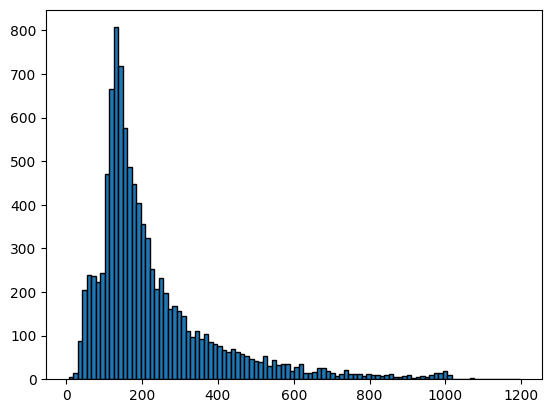

In [ ]:
plot_word_count_histogram(word_counts, bins=100)

### Create subset

In [ ]:
percentile_lower, percentile_upper = calculate_percentiles(word_counts, 10, 90)
percentile_lower, percentile_upper

(89.0, 449.0)

In [ ]:
test_df = remove_rows_by_word_count(test_df, 'review', percentile_lower, percentile_upper)

In [ ]:
word_counts, average_word_count, word_count_set = get_word_count_stats(test_df, 'review')

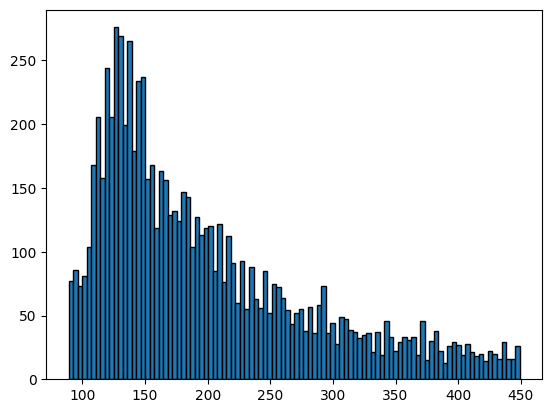

In [ ]:
plot_word_count_histogram(word_counts, bins=100)

In [ ]:
get_value_counts(test_df, 'label')

{1: 4075, 0: 3940}

In [ ]:
model_name_for_tokenization = "Qwen/Qwen2.5-Coder-1.5B-Instruct"

In [ ]:
test_df_450tok= filter_by_token_count(test_df, model_name_for_tokenization, 450, column_name='review')
test_df_450tok

,review,label,token_count
0,Essentially plotless action film has two good ...,1,154
1,I grew up on this movie and I can remember whe...,0,165
2,This was the best movie I've ever seen about B...,0,192
3,This film is about a bunch of misfits who are ...,0,145
4,"Bad plot, bad acting, bad direction.<br /><br ...",1,128
...,...,...,...
9992,'Dead Man Walking' is one of the most powerful...,0,232
9993,"I'm a big fan of Naruto, even though I haven't...",0,339
9995,A beloved and devoted priest from a small town...,0,445
9998,Eddie Monroe is Hooooot. He is a great actor a...,0,164


In [ ]:
word_counts, average_word_count, word_count_set = get_word_count_stats(test_df_450tok, 'review')

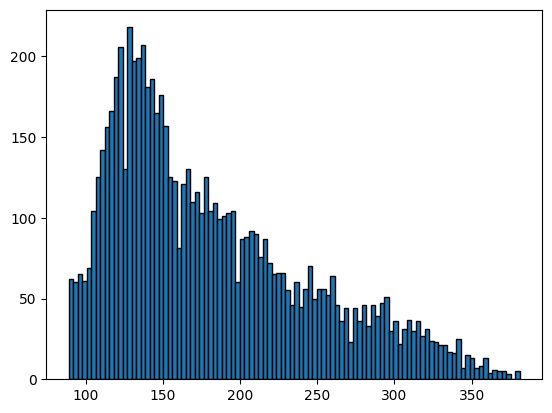

In [ ]:
plot_word_count_histogram(word_counts, bins=100)

In [ ]:
get_value_counts(test_df_450tok, 'label')

{1: 3721, 0: 3620}

In [ ]:
test_df_20_samples = balanced_subset(test_df_450tok, 10) #subseting

In [ ]:
test_df_20_samples

,review,label,token_count
0,"When I stepped into the theater, I thought thi...",0,258
17,"I usually love teen/high school genre flicks, ...",1,150
15,It is incredible that there were two films wit...,1,154
1,Many horror fans complain that horror has scar...,0,246
8,I must say that I had wanted to see this film ...,0,154
5,"this movie has a great message,a impressive ca...",0,187
11,The Slackers as titled in this movie are three...,1,256
3,Some less than inspired opening string music n...,0,332
18,"This movie was so unrelentingly bad, I could h...",1,314
16,Return to Frogtown was a hard film to track do...,1,260


In [ ]:
test_df_20_samples = add_columns(test_df_20_samples)

In [ ]:
word_counts, average_word_count, word_count_set = get_word_count_stats(test_df_20_samples, 'review')

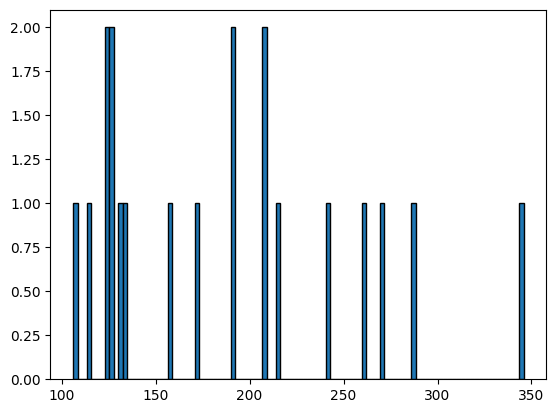

In [ ]:
plot_word_count_histogram(word_counts, bins=100)

### Load models and define system prompt

In [ ]:
repo_id_Qwen_small="bartowski/Qwen2.5-0.5B-Instruct-GGUF"
filename_Qwen_small="*Q5_K_M.gguf"
repo_id_Qwen_large="bartowski/Qwen2.5-1.5B-Instruct-GGUF"
filename_Qwen_large="Qwen2.5-1.5B-Instruct-IQ2_M.gguf"

In [ ]:
 llm_Qwen_large =  make_llm(repo_id_Qwen_large, filename_Qwen_large)

Qwen2.5-1.5B-Instruct-IQ2_M.gguf:   0%|          | 0.00/601M [00:00<?, ?B/s]

In [ ]:
llm_Qwen_small = make_llm(repo_id_Qwen_small, filename_Qwen_small)

Qwen2.5-0.5B-Instruct-Q5_K_M.gguf:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [ ]:
system_prompt = "You are a sentiment analysis expert. Your task is to classify the sentiment of movie reviews."

### Predictions for for 20-sample subset

#### Small model

In [ ]:
test_df_prediction_small_model= get_output_column_with_batches(test_df_20_samples,
                                                              llm_Qwen_small,
                                                              system_prompt,
                                                              0,
                                                              0,
                                                              0,
                                                              batch_size=1)
test_df_prediction_small_model = get_binary_output_column(test_df_prediction_small_model)
test_df_prediction_small_model

Processing batches: 100%|██████████| 20/20 [06:16<00:00, 18.81s/it]


,review,label,token_count,predicted_label,binary_predicted_label
0,"When I stepped into the theater, I thought thi...",0,258,positive,0.0
17,"I usually love teen/high school genre flicks, ...",1,150,negative,1.0
15,It is incredible that there were two films wit...,1,154,positive,0.0
1,Many horror fans complain that horror has scar...,0,246,positive,0.0
8,I must say that I had wanted to see this film ...,0,154,positive,0.0
5,"this movie has a great message,a impressive ca...",0,187,positive,0.0
11,The Slackers as titled in this movie are three...,1,256,negative,1.0
3,Some less than inspired opening string music n...,0,332,positive,0.0
18,"This movie was so unrelentingly bad, I could h...",1,314,negative,1.0
16,Return to Frogtown was a hard film to track do...,1,260,negative,1.0


In [ ]:
[accuracy_small_20, f1_score_small_20, precision_small_20, recall_small_20] = compute_standard_metrics(
    list(test_df_prediction_small_model["binary_predicted_label"]),
    list(test_df_prediction_small_model["label"]),
    accuracy_metric,
    f1_metric,
    precision_metric,
    recall_metric)
print([accuracy_small_20, f1_score_small_20, precision_small_20, recall_small_20])

[0.9, 0.898989898989899, 0.9166666666666667, 0.9]


#### Large model

In [ ]:
test_df_prediction_large_model= get_output_column_with_batches(test_df_20_samples,
                                                              llm_Qwen_large,
                                                              system_prompt,
                                                              0,
                                                              0,
                                                              0,
                                                              batch_size=1)
test_df_prediction_large_model

Processing batches: 100%|██████████| 20/20 [20:57<00:00, 62.86s/it]


,review,label,predicted_label,binary_predicted_label
0,"When I stepped into the theater, I thought thi...",0,positive,0
17,"I usually love teen/high school genre flicks, ...",1,negative,1
15,It is incredible that there were two films wit...,1,negative,0
1,Many horror fans complain that horror has scar...,0,positive,0
8,I must say that I had wanted to see this film ...,0,positive,0
5,"this movie has a great message,a impressive ca...",0,positive,0
11,The Slackers as titled in this movie are three...,1,negative,1
3,Some less than inspired opening string music n...,0,Positive,0
18,"This movie was so unrelentingly bad, I could h...",1,negative,1
16,Return to Frogtown was a hard film to track do...,1,negative,1


In [ ]:
test_df_prediction_large_model = get_binary_output_column(test_df_prediction_large_model)
test_df_prediction_large_model

,review,label,predicted_label,binary_predicted_label
0,"When I stepped into the theater, I thought thi...",0,positive,0
17,"I usually love teen/high school genre flicks, ...",1,negative,1
15,It is incredible that there were two films wit...,1,negative,1
1,Many horror fans complain that horror has scar...,0,positive,0
8,I must say that I had wanted to see this film ...,0,positive,0
5,"this movie has a great message,a impressive ca...",0,positive,0
11,The Slackers as titled in this movie are three...,1,negative,1
3,Some less than inspired opening string music n...,0,Positive,0
18,"This movie was so unrelentingly bad, I could h...",1,negative,1
16,Return to Frogtown was a hard film to track do...,1,negative,1


In [ ]:
[accuracy_large_20, f1_score_large_20, precision_large_20, recall_large_20] = compute_standard_metrics(
    list(test_df_prediction_large_model["binary_predicted_label"]),
    list(test_df_prediction_large_model["label"]),
    accuracy_metric,
    f1_metric,
    precision_metric,
    recall_metric)
print([accuracy_large_20, f1_score_large_20, precision_large_20, recall_large_20])

[0.95, 0.949874686716792, 0.9545454545454546, 0.95]


### Get confusion matrix

In [ ]:
report_confusion_matrix(test_df_prediction_small_model)

array([[[10,  1],
        [ 0,  9]],

       [[ 9,  0],
        [ 1, 10]]])

In [ ]:
report_confusion_matrix(test_df_prediction_large_model)

array([[[10,  1],
        [ 0,  9]],

       [[ 9,  0],
        [ 1, 10]]])

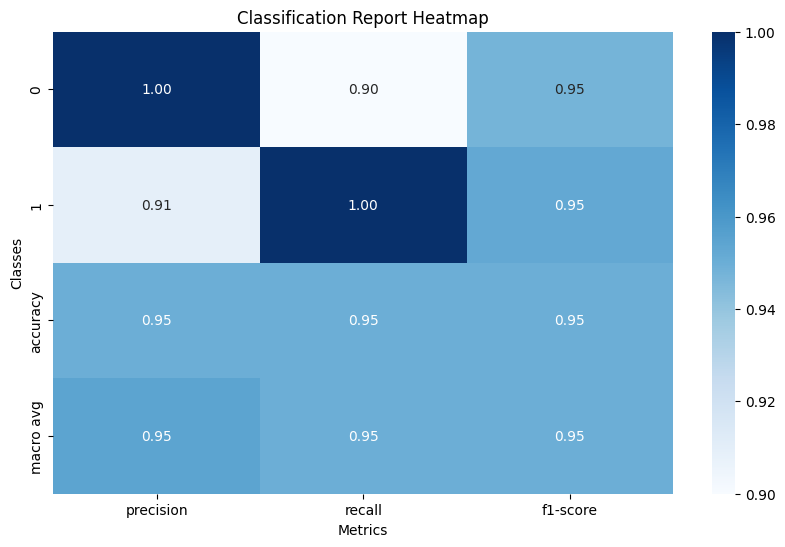

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



In [ ]:
classification_report_reported_large_model = report_classification_report(test_df_prediction_large_model)
print(classification_report_reported_large_model)

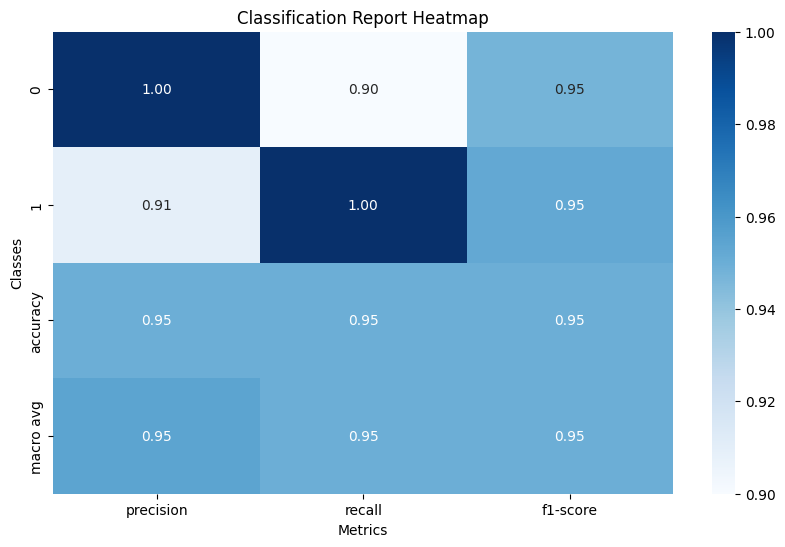

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



In [ ]:
classification_report_reported_small_model = report_classification_report(test_df_prediction_small_model)
print(classification_report_reported_small_model)

### Identify prediction differences between small and large model

In [ ]:
comparing_predictions_large = compare_predictions(list(test_df_prediction_large_model["binary_predicted_label"]),
                                                  list(test_df_prediction_large_model["label"]))
comparing_predictions_large

[12]

In [ ]:
comparing_predictions_small= compare_predictions(list(test_df_prediction_small_model["binary_predicted_label"]),
                                                 list(test_df_prediction_small_model["label"]))
comparing_predictions_small

[12]

In [ ]:
test_df_prediction_small_model["review"][12]

"I'm not sure how related they are, but I'm almost certain that Lost and Delirious is a remake of this movie (or the story that it's based on). Very similar plotline, and even some of the scenes and sets seem to be very, very similar. Lost & Delirious is actually a much better movie, so see that one instead.<br /><br />This one moves very slowly, but being a late 60s French movie, that is to be expected of the style. Told in a retrospect from the perspective of one of the girls revisiting the school. The editing of the flashbacks with the current scenes is a little bit confusing at first, particularly since the audio from each overlaps (ie, hearing flashbacks while seeing the present and vice versa). Also, the 'girls' are a bit old to think that they are in a boarding school. Finally, not much character development to even get you attached to the movie."

### Plot metrics for small and large model

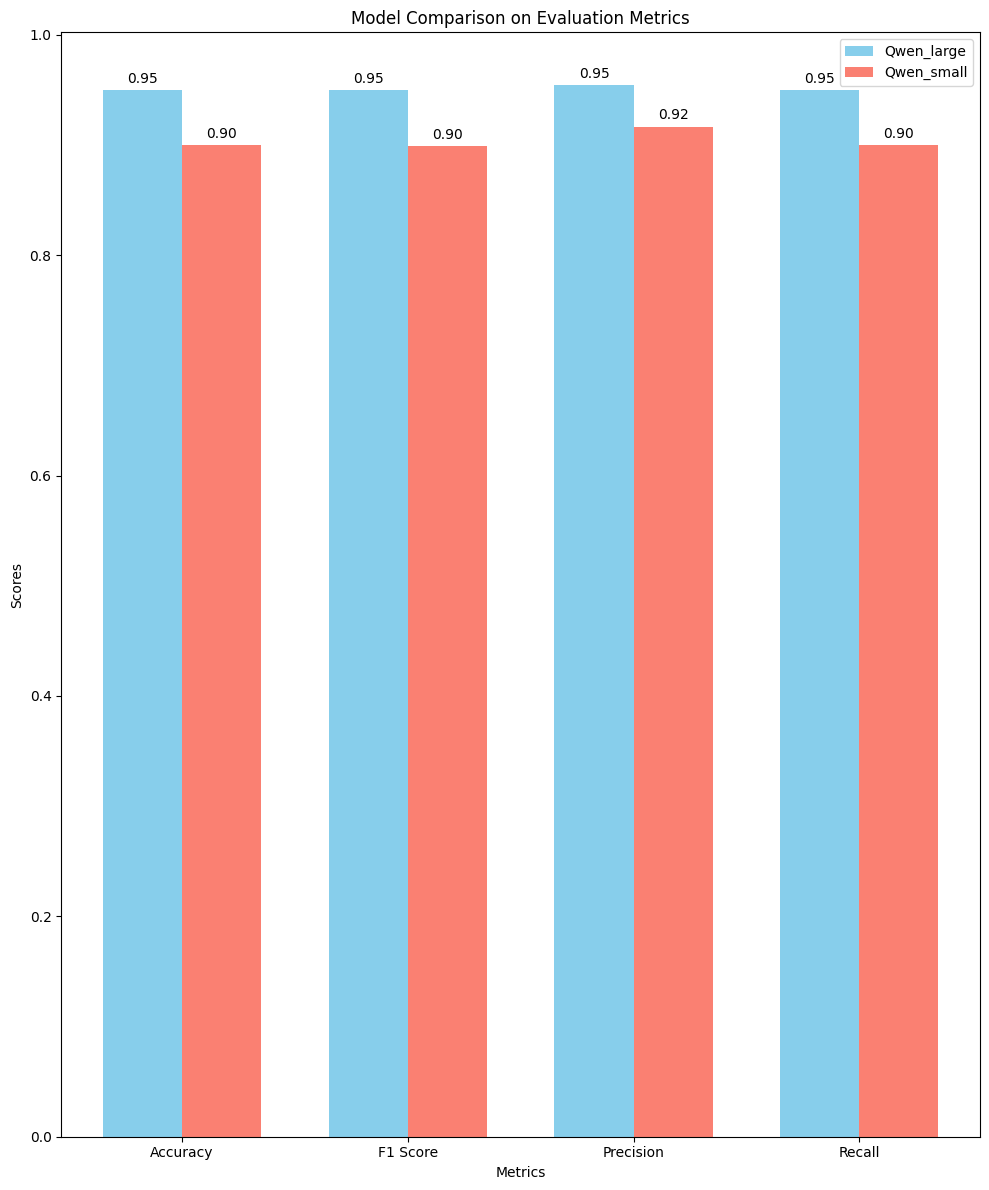

In [ ]:
plot_model_comparison([accuracy_large_20, f1_score_large_20, precision_large_20, recall_large_20],
 [accuracy_small_20, f1_score_small_20, precision_small_20, recall_small_20])

### Grid search

In [ ]:
top_p_list = [0.8,  0.9]
top_k_list = [5, 10]

In [ ]:
def get_scores(df, llm, system_prompt, top_p_list, temperature, top_k_list, batch_size):
  scores_dict = {}
  for i in top_p_list:
      for j in top_k_list:
        print(f"top_p: {i}, top_k: {j}")
        df_prediction = get_output_column_with_batches(df,
                                                      llm,
                                                      system_prompt,
                                                      top_p=i,
                                                      temperature=0,
                                                      top_k=j,
                                                      batch_size=batch_size)
        df_prediction = get_binary_output_column(df_prediction)
        [accuracy, f1_score, precision, recall] = compute_standard_metrics(
          list(df_prediction["binary_predicted_label"]),
          list(df_prediction["label"]),
          accuracy_metric,
          f1_metric,
          precision_metric,
          recall_metric)
        scores_dict[f"top_p_{i}_top_k_{j}"] = [accuracy, f1_score, precision, recall]
  return scores_dict


#### grid search for 20 samples

In [ ]:
scores_dict = get_scores(test_df_20_samples, llm_Qwen_small, system_prompt, top_p_list, 0, top_k_list, 1)

top_p: 0.8, top_k: 5


Processing batches: 100%|██████████| 20/20 [03:56<00:00, 11.85s/it]


top_p: 0.8, top_k: 10


Processing batches: 100%|██████████| 20/20 [03:47<00:00, 11.38s/it]


top_p: 0.9, top_k: 5


Processing batches: 100%|██████████| 20/20 [03:47<00:00, 11.36s/it]


top_p: 0.9, top_k: 10


Processing batches: 100%|██████████| 20/20 [03:46<00:00, 11.31s/it]


In [ ]:
scores_dict

{'top_p_0.8_top_k_5': [0.9, 0.898989898989899, 0.9166666666666667, 0.9],
 'top_p_0.8_top_k_10': [0.9, 0.898989898989899, 0.9166666666666667, 0.9],
 'top_p_0.9_top_k_5': [0.9, 0.898989898989899, 0.9166666666666667, 0.9],
 'top_p_0.9_top_k_10': [0.9, 0.898989898989899, 0.9166666666666667, 0.9]}

In [ ]:
scores_dict_2 = get_scores(test_df_20_samples, llm_Qwen_small, system_prompt, top_p_list, 0, top_k_list, 8 )
scores_dict_2

Processing batches: 100%|██████████| 3/3 [03:49<00:00, 76.43s/it]


{'top_p_0.8_top_k_5': [0.9, 0.898989898989899, 0.9166666666666667, 0.9],
 'top_p_0.8_top_k_10': [0.9, 0.898989898989899, 0.9166666666666667, 0.9],
 'top_p_0.9_top_k_5': [0.9, 0.898989898989899, 0.9166666666666667, 0.9],
 'top_p_0.9_top_k_10': [0.9, 0.898989898989899, 0.9166666666666667, 0.9]}

### Get few-shot examples

In [ ]:
train_df

,review,label,word_count
0,"Ms Aparna Sen, the maker of Mr & Mrs Iyer, dir...",0,394
1,"I have seen this film only once, on TV, and it...",0,125
2,I was only fourteen when I first saw the Alien...,1,272
3,This marvelous short will hit home with everyo...,0,146
4,If you are 10 years old and never seen a movie...,1,44
...,...,...,...
39995,"Why is it that any film about Cleopatra, the l...",1,131
39996,In the area of movies based off of screenplays...,0,702
39997,A recent survey of children in the UK re-enfor...,0,512
39998,Absolute must see documentary for anyone inter...,0,65


In [ ]:
train_df_examples = remove_rows_by_word_count(train_df, 'review', 3, 12)
train_df_examples

,review,label
3952,This movie is terrible but it has some good ef...,1
4033,Adrian Pasdar is excellent is this film. He ma...,0
12782,"More suspenseful, more subtle, much, much more...",1
16453,Primary plot!Primary direction!Poor interpreta...,1
19644,Ming The Merciless does a little Bardwork and ...,1
24348,I hope this group of film-makers never re-unites.,1
29771,Brilliant and moving performances by Tom Court...,0
35282,You'd better choose Paul Verhoeven's even if y...,1
39308,"What a script, what a story, what a mess!",1


In [ ]:
train_df_examples = balanced_subset(train_df_examples, 1)
train_df_examples

,review,label
1,This movie is terrible but it has some good ef...,1
0,Brilliant and moving performances by Tom Court...,0


In [ ]:
examples = give_few_shot_examples(train_df_examples)
examples

'This movie is terrible but it has some good effects. -> negative\nBrilliant and moving performances by Tom Courtenay and Peter Finch. -> positive'

### Few-shot predictions of small model on 64-sample subset

In [ ]:
test_df_64_samples = balanced_subset(test_df_450tok, 32) #subseting
test_df_64_samples

,review,label,token_count
52,Cage (1989) was another one of those low budge...,1,287
58,I was wondering when someone would try turning...,1,284
0,"When I stepped into the theater, I thought thi...",0,258
44,Denzel is about the only thing that is right i...,1,152
5,"this movie has a great message,a impressive ca...",0,187
...,...,...,...
42,"Kudos to the patience of Paul Muni, who spent ...",1,339
14,"The End of Suburbia, as it should appeal to ge...",0,378
28,'Oldboy' director Park Chun-wook returns with ...,0,296
51,"This film seems well made, and more efforts sh...",1,310


In [ ]:
test_df_64_samples = add_columns(test_df_64_samples)

In [ ]:
test_df_prediction_with_examples = get_output_column_with_batches_with_few_shot_examples(test_df_64_samples, llm_Qwen_small, system_prompt, 0.9, 0, 5, 8, examples)
test_df_prediction_with_examples

Processing batches: 100%|██████████| 8/8 [13:39<00:00, 102.49s/it]


,review,label,predicted_label
52,The movie is about a day in the life of a woma...,1,positive
58,I can't remember when was the last time I have...,1,positive
0,"Well I don't know much about anything, but I s...",0,positive
44,"And one only, in my opinion.<br /><br />That r...",1,positive
5,"As I have said before in previous comments, so...",0,positive
...,...,...,...
42,I don't understand what is hard hitting about ...,1,negative
14,I saw this last night in Fort Lauderdale. In g...,0,positive
28,I saw a special advance screening of this toda...,0,positive
51,After wasting 2 hours of my life watching this...,1,negative


In [ ]:
test_df_prediction_with_examples  = get_binary_output_column(test_df_prediction_with_examples )
test_df_prediction_with_examples

,review,label,predicted_label,binary_predicted_label
52,The movie is about a day in the life of a woma...,1,positive,0.0
58,I can't remember when was the last time I have...,1,positive,0.0
0,"Well I don't know much about anything, but I s...",0,positive,0.0
44,"And one only, in my opinion.<br /><br />That r...",1,positive,0.0
5,"As I have said before in previous comments, so...",0,positive,0.0
...,...,...,...,...
42,I don't understand what is hard hitting about ...,1,negative,1.0
14,I saw this last night in Fort Lauderdale. In g...,0,positive,0.0
28,I saw a special advance screening of this toda...,0,positive,0.0
51,After wasting 2 hours of my life watching this...,1,negative,1.0


In [ ]:
[accuracy_small_fewshot_64, f1_score_small_fewshot_64, precision_small_fewshot_64, recall_small_fewshot_64] = compute_standard_metrics(
    list(test_df_prediction_with_examples["binary_predicted_label"]),
    list(test_df_prediction_with_examples["label"]),
    accuracy_metric,
    f1_metric,
    precision_metric,
    recall_metric)
print([accuracy_small_fewshot_64, f1_score_small_fewshot_64, precision_small_fewshot_64, recall_small_fewshot_64])

In [ ]:
comparing_predictions_small_with_examples = compare_predictions(list(test_df_prediction_with_examples["binary_predicted_label"]),
                                                                list(test_df_prediction_with_examples["label"]))
comparing_predictions_small_with_examples

[0, 1, 3, 9, 10, 12, 18, 25, 26, 36, 38, 48, 49, 52, 56, 63]

In [ ]:
test_df_64_samples = add_columns(test_df_64_samples)
test_df_64_samples

,review,label,predicted_label,binary_predicted_label
52,Cage (1989) was another one of those low budge...,1,None,None
58,I was wondering when someone would try turning...,1,None,None
0,"When I stepped into the theater, I thought thi...",0,None,None
44,Denzel is about the only thing that is right i...,1,None,None
5,"this movie has a great message,a impressive ca...",0,None,None
...,...,...,...,...
42,"Kudos to the patience of Paul Muni, who spent ...",1,None,None
14,"The End of Suburbia, as it should appeal to ge...",0,None,None
28,'Oldboy' director Park Chun-wook returns with ...,0,None,None
51,"This film seems well made, and more efforts sh...",1,None,None


### Predictions when prompted to output reasoning and confidence score on 64-sample subset

In [ ]:
test_df_scores = get_output_column_with_batches_with_confidence_scores(test_df_64_samples, llm_Qwen_small, system_prompt,  0.9, 0, 5, 8)
test_df_scores = get_binary_output_column(test_df_scores)
print(test_df_scores)
test_df_scores.to_csv("test_df_scores.csv", sep="\t", index=False)

### Predictions when prompted to output reasoning and confidence score with seprator on 62-sample subset

#### Remove too long samples after increasing prompt length

In [ ]:
test_df_64_samples_filtered = filter_by_token_count(test_df_64_samples, model_name_for_tokenization, 420, column_name='review')
len(test_df_64_samples_filtered)

62

In [ ]:
test_df_scores_seprator = get_output_column_with_batches_with_confidence_scores_seprator(test_df_64_samples_filtered, llm_Qwen_small, system_prompt,  0.9, 0, 5, 8)
test_df_scores_seprator = get_binary_output_column(test_df_scores_seprator)

Processing batches: 100%|██████████| 8/8 [18:05<00:00, 135.72s/it]

['negative|0.9|The review is predominantly negative, criticizing the film\'s low budget, lack of quality, and poor execution. The reviewer expresses disappointment and frustration with the film, calling it a "waste of time" and recommending it not to be recommended.', "negative|0.9|The text contains mixed opinions about the film, mentioning both positive and negative aspects. The reviewer seems to be confused about the film's content and the Mexican culture, which could indicate a negative sentiment.", 'positive|0.95|The review is overwhelmingly positive, using phrases like "brilliant", "excellent", and "10/10". The reviewer expresses disappointment and satisfaction with the movie, indicating a positive sentiment.', "negative|0.9|The review expresses disappointment with the movie's pacing, plot, and overall quality, despite mentioning some positive aspects like the acting. The sentiment is overall negative.", 'positive|0.9|The text is overwhelmingly positive, praising the cast, the dir


<ipython-input-133-dfa2f1573c92>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["predicted_label"] = predicted_labels
<ipython-input-133-dfa2f1573c92>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["reasoning"] = reasonings
<ipython-input-133-dfa2f1573c92>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [ ]:
test_df_scores_seprator

,review,label,token_count,predicted_label,reasoning,confidence_score,binary_predicted_label
52,Cage (1989) was another one of those low budge...,1,287,negative,"The review is predominantly negative, criticiz...",0.9,1.0
58,I was wondering when someone would try turning...,1,284,negative,The text contains mixed opinions about the fil...,0.9,1.0
0,"When I stepped into the theater, I thought thi...",0,258,positive,"The review is overwhelmingly positive, using p...",0.95,0.0
44,Denzel is about the only thing that is right i...,1,152,negative,The review expresses disappointment with the m...,0.9,1.0
5,"this movie has a great message,a impressive ca...",0,187,positive,"The text is overwhelmingly positive, praising ...",0.9,0.0
...,...,...,...,...,...,...,...
42,"Kudos to the patience of Paul Muni, who spent ...",1,339,positive,The review expresses admiration for Paul Muni'...,0.9,0.0
14,"The End of Suburbia, as it should appeal to ge...",0,378,negative,The text expresses disappointment and criticis...,0.9,1.0
28,'Oldboy' director Park Chun-wook returns with ...,0,296,negative,The review criticizes the film for its violenc...,0.9,1.0
51,"This film seems well made, and more efforts sh...",1,310,negative,The text expresses critical opinions about the...,0.9,1.0


In [ ]:
# replace NaN prediction by 0 (i.e. positive)
[accuracy_small_with_scores_sep_62, f1_score_small_with_scores_sep_62, precision_small_with_scores_sep_62, recall_small_with_scores_sep_62] = compute_standard_metrics_int(
    list(test_df_scores_seprator["binary_predicted_label"]),
    list(test_df_scores_seprator["label"]),
    accuracy_metric,
    f1_metric,
    precision_metric,
    recall_metric)
print([accuracy_small_with_scores_sep_62, f1_score_small_with_scores_sep_62, precision_small_with_scores_sep_62, recall_small_with_scores_sep_62])

[0.8225806451612904, 0.8187616263619453, 0.8411371237458194, 0.81875]


In [ ]:
# drop NaN predictions ()
[accuracy_small_with_scores_sep_62, f1_score_small_with_scores_sep_62, precision_small_with_scores_sep_62, recall_small_with_scores_sep_62] = compute_standard_metrics_drop(
    list(test_df_scores_seprator["binary_predicted_label"]),
    list(test_df_scores_seprator["label"]),
    accuracy_metric,
    f1_metric,
    precision_metric,
    recall_metric)
print([accuracy_small_with_scores_sep_62, f1_score_small_with_scores_sep_62, precision_small_with_scores_sep_62, recall_small_with_scores_sep_62])

[0.819672131147541, 0.8146920740127037, 0.8391608391608392, 0.8135775862068966]


In [ ]:
# modify the row which had the wrong output format to -1 label
from copy import deepcopy
test_df_scores_seprator_modified = deepcopy(test_df_scores_seprator)
test_df_scores_seprator_modified.loc[31, "predicted_label"] = -1
test_df_scores_seprator_modified.loc[31, "reasoning"] = ""
test_df_scores_seprator_modified.loc[31, "confidence_score"] = ""
[accuracy_small_model_with_scores_mod , f1_score_small_model_with_scores_mod , precision_small_model_with_scores_mod , recall_small_model_with_scores_mod ] = compute_standard_metrics_drop(
    list(test_df_scores_seprator_modified["binary_predicted_label"]), list(test_df_scores_seprator_modified["label"]), accuracy_metric, f1_metric, precision_metric, recall_metric)
print([accuracy_small_model_with_scores_mod, f1_score_small_model_with_scores_mod , precision_small_model_with_scores_mod , recall_small_model_with_scores_mod ])

[0.819672131147541, 0.8146920740127037, 0.8391608391608392, 0.8135775862068966]


### Predictions of small model on 64-sample subset


In [ ]:
predictions_df_64_samples_small = get_output_column_with_batches(test_df_64_samples, llm_Qwen_small, system_prompt, 0.9, 0, 5, 8)
predictions_df_64_samples_small = get_binary_output_column(predictions_df_64_samples_small)
print(predictions_df_64_samples_small)
predictions_df_64_samples_small.to_csv("predictions_df_64_samples_small.csv", sep="\t", index=False)

Processing batches: 100%|██████████| 8/8 [12:15<00:00, 91.90s/it]

                                               review  label  token_count  \
52  Cage (1989) was another one of those low budge...      1          287   
58  I was wondering when someone would try turning...      1          284   
0   When I stepped into the theater, I thought thi...      0          258   
44  Denzel is about the only thing that is right i...      1          152   
5   this movie has a great message,a impressive ca...      0          187   
..                                                ...    ...          ...   
42  Kudos to the patience of Paul Muni, who spent ...      1          339   
14  The End of Suburbia, as it should appeal to ge...      0          378   
28  'Oldboy' director Park Chun-wook returns with ...      0          296   
51  This film seems well made, and more efforts sh...      1          310   
38  Return to Frogtown was a hard film to track do...      1          260   

   predicted_label  binary_predicted_label  
52        negative            

In [ ]:
# compute scores
[acc_small_64, f1_small_64, precision_small_64, recall_small_64] = compute_standard_metrics(
    list(predictions_df_64_samples_small["binary_predicted_label"]),
    list(predictions_df_64_samples_small["label"]),
    accuracy_metric,
    f1_metric,
    precision_metric,
    recall_metric)
print([acc_small_64, f1_small_64, precision_small_64, recall_small_64])

[0.8125, 0.8108374384236454, 0.8238866396761133, 0.8125]


In [ ]:
#remove 2 longest lines ->compute the score
# identify 2 longest rows
predictions_df_64_samples_small[predictions_df_64_samples_small["token_count"]>420]

,review,label,token_count,predicted_label,binary_predicted_label
27,I had watched this film from Ralph Bakshi (Wiz...,0,442,positive,0.0
7,In celebration of Earth Day Disney has release...,0,427,positive,0.0


In [ ]:
# remove 2 longest rows
predictions_df_62_samples_small = predictions_df_64_samples_small[predictions_df_64_samples_small["token_count"]<=420]

In [ ]:
# compute scores
[acc_small_62, f1_small_62 , precision_small_62 , recall_small_62] = compute_standard_metrics(
    list(predictions_df_62_samples_small["binary_predicted_label"]),
    list(predictions_df_62_samples_small["label"]),
    accuracy_metric,
    f1_metric,
    precision_metric,
    recall_metric)
print([acc_small_62, f1_small_62 , precision_small_62 , recall_small_62])

[0.8225806451612904, 0.8202898550724638, 0.8500557413600892, 0.8270833333333334]


### Predictions of large model on 64-sample subset

---



In [ ]:
predictions_df_64_samples_large = get_output_column_with_batches(test_df_64_samples, llm_Qwen_large, system_prompt,  0.9, 0, 5, 8)
predictions_df_64_samples_large = get_binary_output_column(predictions_df_64_samples_large)
print(predictions_df_64_samples_large)
predictions_df_64_samples_large.to_csv("predictions_df_64_samples_large.csv", sep="\t", index=False)

Processing batches: 100%|██████████| 8/8 [1:01:21<00:00, 460.14s/it]

                                               review  label  token_count  \
52  Cage (1989) was another one of those low budge...      1          287   
58  I was wondering when someone would try turning...      1          284   
0   When I stepped into the theater, I thought thi...      0          258   
44  Denzel is about the only thing that is right i...      1          152   
5   this movie has a great message,a impressive ca...      0          187   
..                                                ...    ...          ...   
42  Kudos to the patience of Paul Muni, who spent ...      1          339   
14  The End of Suburbia, as it should appeal to ge...      0          378   
28  'Oldboy' director Park Chun-wook returns with ...      0          296   
51  This film seems well made, and more efforts sh...      1          310   
38  Return to Frogtown was a hard film to track do...      1          260   

   predicted_label  binary_predicted_label  
52        negative            

In [ ]:
# compute scores
[acc_large_64, f1_large_64 , precision_large_64, recall_large_64] = compute_standard_metrics(
    list(predictions_df_64_samples_large["binary_predicted_label"]),
    list(predictions_df_64_samples_large["label"]),
    accuracy_metric,
    f1_metric,
    precision_metric,
    recall_metric)
print([acc_large_64, f1_large_64 , precision_large_64, recall_large_64])

[0.8125, 0.8108374384236454, 0.8238866396761133, 0.8125]


### Remove 2 longest reviews (for comparison with reasoning prompt)

In [ ]:
# remove 2 longest rows
predictions_df_62_samples_large = predictions_df_64_samples_large[predictions_df_64_samples_large["token_count"]<=420]
assert len(predictions_df_62_samples_large) == 62

In [ ]:
# compute scores
[acc_large_62, f1_large_62 , precision_large_62, recall_large_62] = compute_standard_metrics(
    list(predictions_df_62_samples_large["binary_predicted_label"]),
    list(predictions_df_62_samples_large["label"]),
    accuracy_metric,
    f1_metric,
    precision_metric,
    recall_metric)
print([acc_large_62, f1_large_62 , precision_large_62, recall_large_62])

[0.8064516129032258, 0.8031746031746032, 0.819078947368421, 0.803125]


### Error analysis

In [255]:
comparing_predictions_small_64 = compare_predictions(list(predictions_df_64_samples_small["binary_predicted_label"]),
                                                                list(predictions_df_64_samples_small["label"]))
comparing_predictions_small_64

[11, 27, 29, 32, 37, 51, 53, 57, 59, 60, 61, 62]

In [263]:
comparing_predictions_large_64 = compare_predictions(list(predictions_df_64_samples_large["binary_predicted_label"]),
                                                                list(predictions_df_64_samples_large["label"]))
comparing_predictions_large_64

[11, 27, 29, 32, 37, 51, 53, 57, 59, 60, 61, 62]

Token lengths of misclassified reviews

[210, 442, 137, 150, 154, 310, 155, 402, 163, 244, 183, 248]


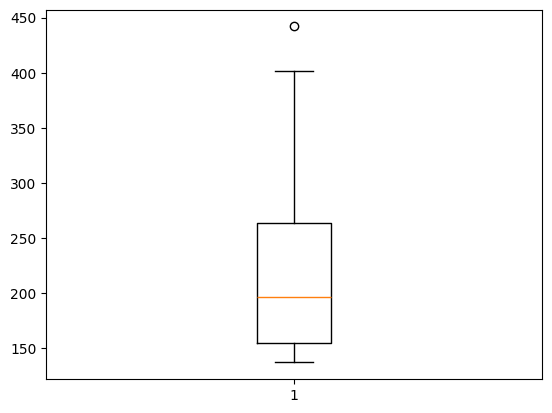

mean: 233.16666666666666
std: 97.84156694484314


In [261]:
misclassified_token_lengths_small = [predictions_df_64_samples_small.loc[i, "token_count"] for i in comparing_predictions_small_64]
print(misclassified_token_lengths_small)
plt.boxplot(misclassified_token_lengths_small)
plt.show()
print("mean:", np.mean(misclassified_token_lengths_small))
print("std:", np.std(misclassified_token_lengths_small))